In [1]:
#!pip install hopsworks==4.1.3
#!pip install requests_cache
#!pip install retry_requests
#!pip install google_play_scraper

    pyparsing (>=2.4*) ; python_version >= "3.5"
              ~~~~~~^


In [1]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
from sklearn.svm import LinearSVC
import hopsworks
import json
from functions import util
import os

2025-01-10 11:03:28.102204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 11:03:28.154507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 11:03:28.170186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 11:03:28.207485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 11:03:31.004490: W tensorflow/compiler/tf2

# Collecting data

In [2]:
df = util.get_last_week_reviews('com.tinder', 'en', 'us')

Fetched 776 reviews from 2025-01-03 to 2025-01-10.


In [3]:
df.dropna(inplace=True)
df

,reviewId,content,score,at,thumbsUpCount
0,cf75a0f8-823a-4a73-8cc0-dd5099d53292,nice experience,5,2025-01-09 10:43:53,0
1,11b14078-3d34-4524-b77b-1896832f7506,Poor,2,2025-01-09 10:15:20,0
2,62983208-0400-477e-befa-abf9fab1b046,Good,2,2025-01-09 10:14:29,0
3,5d685059-423a-42a8-bc38-9f377508e228,bots,1,2025-01-09 10:12:57,0
4,bc5fb768-bb01-4a7a-b17e-9b624a9dfcd8,Works great!,5,2025-01-09 10:12:07,0
...,...,...,...,...,...
771,fe26c517-3c46-449b-be11-f0e3dfda0bec,i love tinder dating website,5,2025-01-03 01:04:25,0
772,d3d37ebd-bae9-43a5-ab1d-4fb0fe671519,Got banned for no reason at all and cannot app...,1,2025-01-03 00:38:20,0
773,31c8fe97-7023-4ad7-a037-4398c7881ef8,Its a very bad app cuz i dont know how to matc...,1,2025-01-03 00:19:05,0
774,b882cc37-8dc4-4604-b2f5-68d789e08a51,Banned by the AI for being trans.,1,2025-01-03 00:16:39,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 775
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       776 non-null    object        
 1   content        776 non-null    object        
 2   score          776 non-null    int64         
 3   at             776 non-null    datetime64[ns]
 4   thumbsUpCount  776 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 36.4+ KB


In [5]:
df['content'] = df['content'].astype(str)  # Convert 'content' to string

In [6]:
os.environ["HOPSWORKS_API_KEY"] = "6xLHrUPek6nw9STy.ueYbHCnUwYhFQ5xzscRiONFQ4ZmgUxMFUt8bnCu3UX69ejYcaIxeUHynvrMhcrt5"

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-10 11:03:53,517 INFO: Initializing external client
2025-01-10 11:03:53,524 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-10 11:03:54,965 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1185941


In [9]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="linear_svc_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [10]:
import joblib
retrieved_linear_svc_model = joblib.load(saved_model_dir + "/model.pkl")
retrieved_linear_svc_model

LinearSVC()

# Preprocessing the collected data :

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Let's clean our dataset
import nltk
nltk.download('stopwords')
## remove stopwords and punctuation marks
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)

corpus = df['content'].tolist()
print(len(corpus))
print(corpus[0])

776
nice experience


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jouteix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
%%time
nltk.download('wordnet')
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['content'][i])
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text
            if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

[nltk_data] Downloading package wordnet to /home/jouteix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 7.95 s, sys: 307 ms, total: 8.26 s
Wall time: 8.27 s


In [14]:
df["content_cleaned"] = final_corpus_joined

In [15]:
vectorizer_model_hopsworks = mr.get_model("vectorizer", version=1)
# Download the saved model artifacts to a local directory
vectorizer_model = vectorizer_model_hopsworks.download()
tfidf = joblib.load(vectorizer_model+"/vectorizer.pkl")
print(vectorizer_model)


/tmp/f1d5724f-376d-4b37-8faf-36dc2c2925a8/vectorizer/1


In [16]:
vector = tfidf.transform(df['content_cleaned'])

In [17]:
print(len(tfidf.vocabulary_))

15006


# Classifying our reviews :

In [18]:
df['sentiment'] = retrieved_linear_svc_model.predict(vector)
df.dropna(inplace=True)
df

,reviewId,content,score,at,thumbsUpCount,content_cleaned,sentiment
0,cf75a0f8-823a-4a73-8cc0-dd5099d53292,nice experience,5,2025-01-09 10:43:53,0,nice experience,1
1,11b14078-3d34-4524-b77b-1896832f7506,Poor,2,2025-01-09 10:15:20,0,poor,0
2,62983208-0400-477e-befa-abf9fab1b046,Good,2,2025-01-09 10:14:29,0,good,1
3,5d685059-423a-42a8-bc38-9f377508e228,bots,1,2025-01-09 10:12:57,0,bot,1
4,bc5fb768-bb01-4a7a-b17e-9b624a9dfcd8,Works great!,5,2025-01-09 10:12:07,0,work great,1
...,...,...,...,...,...,...,...
771,fe26c517-3c46-449b-be11-f0e3dfda0bec,i love tinder dating website,5,2025-01-03 01:04:25,0,love tinder dating website,1
772,d3d37ebd-bae9-43a5-ab1d-4fb0fe671519,Got banned for no reason at all and cannot app...,1,2025-01-03 00:38:20,0,got banned reason cannot appeal doesnt matter ...,1
773,31c8fe97-7023-4ad7-a037-4398c7881ef8,Its a very bad app cuz i dont know how to matc...,1,2025-01-03 00:19:05,0,bad app cuz dont know match puzzle even try st...,0
774,b882cc37-8dc4-4604-b2f5-68d789e08a51,Banned by the AI for being trans.,1,2025-01-03 00:16:39,0,banned ai trans,0


In [22]:
feature_group = fs.get_or_create_feature_group(
    name="reviews_sentiment",
    version=1,
    description="Sentiment predictions for reviews",
    primary_key=["reviewId"],
    event_time="at"
)
feature_group.insert(df, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████████████████████████| Rows 776/776 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: reviews_sentiment_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1185941/jobs/named/reviews_sentiment_1_offline_fg_materialization/executions
2025-01-10 11:14:09,326 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-10 11:14:12,566 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-10 11:16:16,749 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-10 11:16:16,921 INFO: Waiting for log aggregation to finish.
2025-01-10 11:16:42,709 INFO: Execution finished successfully.


(Job('reviews_sentiment_1_offline_fg_materialization', 'SPARK'), None)

In [23]:
# Candidate topics for classification
candidate_topics = [
    "Pricing", "User Experience", "Performance", "Support", "Bugs",
    "Privacy", "Spam/Bots", "Matches", "Accessibility", "Content Moderation"
]
# Classify topics with sentiment
df, topic_counts = util.classify_topics_with_sentiment(df, candidate_topics)

# Save the updated DataFrame
df.to_csv("classified_reviews.csv", index=False)

# Display topic counts
print(topic_counts)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


topic      Accessibility  Bugs  Content Moderation  Matches  Performance  \
sentiment                                                                  
0                      4    17                  11       50           21   
1                      9     3                  33       52           75   

topic      Pricing  Privacy  Spam/Bots  Support  User Experience  
sentiment                                                         
0               26       21         60       41               97  
1               34        6         14      127               75  


In [ ]:
topic_feature_group = fs.get_or_create_feature_group(
    name="topic_sentiment",
    version=1,
    description="Topic classification with sentiment counts",
    primary_key=["topic"],
)
topic_counts_df = pd.DataFrame(topic_counts.items(), columns=["topic", "count"])
topic_feature_group.insert(topic_counts_df, write_options={"wait_for_job": True})

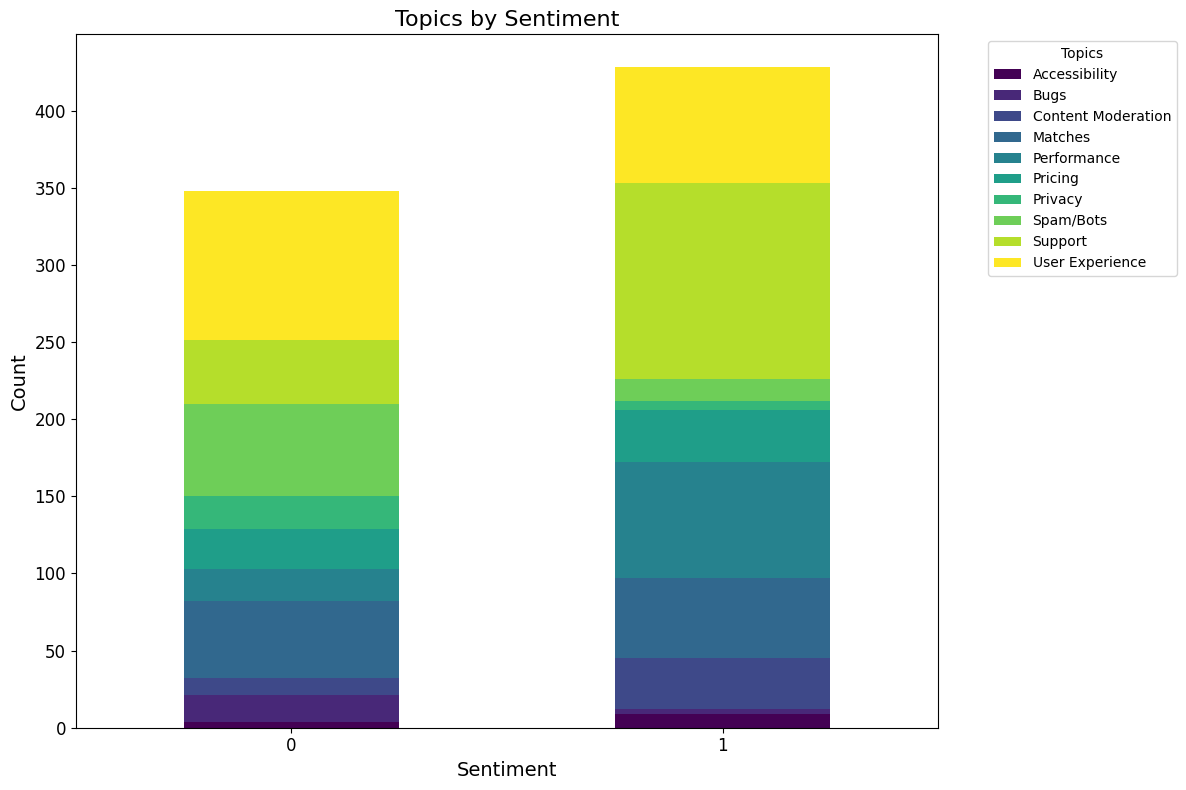

In [26]:
# Plot topics by sentiment
file_path = "../docs/sentiment/assets/img/sentiment_topics.png"
plt = util.plot_sentiment_topics(topic_counts, file_path)
plt.show()